In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']


In [2]:
tss_annotation = doc['tss_annotation']

In [3]:

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Modules.Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 16)


In [4]:
meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=2)
meta_samples.head()

,Unnamed: 0,Experiment,Short,Short_with_number,Tissue
Full,,,,,
/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak,BMDMwt/GRO/f04_peaks/merge_bg_2.peak,GRO,BMDMwt_GRO,BMDMwt_GRO1,BMDMwt
/data/isshamie/TSS/Processed/Brain/GRO/f04_peaks/merge_bg_2.peak,Brain/GRO/f04_peaks/merge_bg_2.peak,GRO,Brain_GRO,Brain_GRO1,Brain
/data/isshamie/TSS/Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak,Brain/mSTART/f04_peaks/merge_bg_2.peak,mSTART,Brain_mSTART,Brain_mSTART1,Brain
/data/isshamie/TSS/Processed/Heart/mSTART/f04_peaks/merge_bg_2.peak,Heart/mSTART/f04_peaks/merge_bg_2.peak,mSTART,Heart_mSTART,Heart_mSTART1,Heart
/data/isshamie/TSS/Processed/Kidney/GRO/f04_peaks/merge_bg_2.peak,Kidney/GRO/f04_peaks/merge_bg_2.peak,GRO,Kidney_GRO,Kidney_GRO1,Kidney


## Load anno_peaks. 
Later will filter based on Distance to TSS

## Load peaks_tissues matrix
Later will be used to merge two data types in a tissue and for more confident peaks if they have more than 1 tissues present

## Load tss

## Load txn_df

## Load gene_df



In [5]:
anno_peaks = pd.read_csv('Results/peaks_with_tss_and_gene.tsv',sep='\t',index_col=0)
anno_peaks.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Distance to TSS,Nearest PromoterID,Nearest TSS,isSameStrand,Nearest gene,Nearest gene_id
PeakID (cmd=annotatePeaks.pl Results/merged/all_peaks_merged.tsv /data/isshamie/genome/picr.fa -gff /data/isshamie/genome/updated_final_sort.gff3),,,,,,,,,,,,,
Merged-picr_48-1084706-14,picr_48,1084630,1084782,+,50717.441406,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,TTS (ID=asmbl_56918.exon2;Parent=asmbl_56918;g...,127017.0,ID=asmbl_56919.exon2;Parent=asmbl_56919;gene_i...,asmbl_56916,True,MTHFD1L,gene_20259_1
Merged-picr_33-4827737-11,picr_33,4827637,4827815,+,17077.398438,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_45526.exon1;Parent=asmb...,4.0,ID=asmbl_45526.exon1;Parent=asmbl_45526;gene_i...,asmbl_45526,True,CPA2,gene_16120
Merged-picr_13-30535388-7,picr_13,30535313,30535463,+,15631.878906,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,promoter-TSS (ID=asmbl_16617.exon1;Parent=asmb...,-267.0,ID=asmbl_16613.exon1;Parent=asmbl_16613;gene_i...,asmbl_16611,False,PARP16,gene_5744
Merged-picr_64-11363665-15,picr_64,11363590,11363741,+,8920.436523,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,Intergenic,-42355.0,ID=asmbl_69800.exon2;Parent=asmbl_69800;gene_i...,asmbl_69802,True,GRM3,gene_24621
Merged-picr_16-22007181-6,picr_16,22007101,22007263,+,6541.673828,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_24868.exon3;Parent=asmb...,-25868.0,ID=asmbl_24866.exon2;Parent=asmbl_24866;gene_i...,asmbl_24876,True,DSCAML1,gene_8431


In [6]:
peaks_tissue = pd.read_csv("Results/merged/peaks_tissues.csv",index_col=0)
peaks_tissue.head()

,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Brain/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Heart/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Kidney/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Kidney/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Liver/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Liver/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Lung/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Lung/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Muscle/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Pancreas/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Spleen/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/Spleen/mSTART/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/CHO/GRO/f04_peaks/merge_bg_2.peak,/data/isshamie/TSS/Processed/CHO/mSTART/f04_peaks/merge_bg_2.peak
Merged-picr_173-470386-4,3.38,0.000000,0.0,2.735,0.000000,0.000,9.500000,0.00,12.300000,0.0,0.000,0.0,0.00,0.000,0.00,0.000000
Merged-picr_23-695720-7,6.76,2.260000,0.0,2.420,0.000000,3.405,0.000000,0.00,0.000000,0.0,1.410,0.0,0.00,2.690,0.00,5.280000
Merged-picr_7b-957560-9,10.50,1.710000,0.0,2.595,0.000000,0.000,0.000000,3.56,2.150000,0.0,0.000,0.0,2.29,2.755,66.25,54.400002
Merged-picr_15-19045171-9,22.00,54.500000,0.0,3.275,79.800003,8.465,32.400002,0.00,92.400002,0.0,9.300,0.0,25.90,0.000,0.00,0.000000
Merged-picr_62-853143-10,23.50,18.799999,0.0,2.147,17.100000,5.920,12.900000,0.00,21.500000,0.0,2.805,0.0,10.20,0.000,0.00,7.270000


#### Read in tss and txn_df

In [7]:
tss = pd.read_csv(tss_annotation,sep='\t',index_col=0)

tss.head()

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length,actual_start
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gene=SERHL;transcript_id=asmbl_2;cs=2,picr_0,176,38694,+,asmbl_2,gene_1_2,gene_1_2,SERHL,asmbl_2,2,38518,176
ID=asmbl_4;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_4;cs=1,picr_0,7715,46630,-,asmbl_4,gene_2,gene_2,RRP7A,asmbl_4,1,38915,46630
ID=asmbl_7;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_7;cs=1,picr_0,7759,44597,-,asmbl_7,gene_2,gene_2,RRP7A,asmbl_7,1,36838,44597
ID=asmbl_8;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_8;cs=1,picr_0,7767,44597,-,asmbl_8,gene_2,gene_2,RRP7A,asmbl_8,1,36830,44597
ID=asmbl_9;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_9;cs=1,picr_0,7789,44568,-,asmbl_9,gene_2,gene_2,RRP7A,asmbl_9,1,36779,44568


In [8]:
txn_df = pickle.load(open('Results/txn_df.p','rb'))# pd.read_csv('Results/txn_df.csv',index_col=0)
txn_df.head()

,peaks,Closest_to_X_numberOfPeaks,bin_-1000_100,tss_bin_-1000_100,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,Strandgene_id,gene,transcript,gene_id,Strand,hasGene,Number of SS
asmbl_2,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_4,"[Merged-picr_0-45924-1, Merged-picr_0-50486-1,...",3,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_7,[Merged-picr_0-44638-7],1,[Merged-picr_0-44638-7],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_8,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_9,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0


In [9]:
gene_df = pickle.load(open('Results/gene_df.p','rb'))

### Merge tissue columns

In [10]:
def merge_two_columns(df,meta_samples,meta_column='Tissue'):#column_listtissues):
    vals = np.unique(meta_samples[meta_column].values)
    new_df = pd.DataFrame(index=peaks_tissue.index,columns=vals)

    for i in vals:
        if (meta_samples[meta_column] == i).any():
            new_col = (df.loc[:,meta_samples[meta_column] == i])
            new_col = new_col.mean(axis=1)
            new_df.loc[:,i] =  new_col
    
    new_df = new_df.loc[:,~(new_df.isnull().all())]
    return new_df

In [11]:
peaks_tissue_merged = merge_two_columns(peaks_tissue,meta_samples,meta_column='Tissue')

### Create directory of different peak groups

In [60]:
!mkdir Results/peak_groups

In [12]:
def save_peak_as_bed(peaks_df,f_save, name='index',score_col = 'Peak Score',is_sort = True):
    ## Assumes there is Chr,Start,End,Name is index
    ## Peak file is 1-index, bed files are 0, so need to shift everything by one
    
    if name == 'index':
        peaks_df.loc[:,'Name'] = peaks_df.index
    else:
        peaks_df.loc[:,'Name'] = peaks_df[name]
    
    if score_col == '': #If no scoring col, set to 0
        peaks_df.loc[:,'Score'] = 0
        score_col = 'Score'
        
    peaks_df.loc[:,'Start'] = peaks_df['Start'] - 1
    peaks_df.loc[:,'End'] = peaks_df['End'] - 1
    
    peaks_df = peaks_df[['Chr','Start','End','Name',score_col,'Strand']]
    
    if is_sort:
        peaks_df.sort_values(['Chr','Start'],inplace=True)
        
    if not f_save.endswith('.bed'):
        f_save = f_save + '.bed'
    peaks_df.to_csv(f_save ,sep='\t',index=False,header=None)
    return
    

## a) Separate confident promoters and confident ncRNA 
Define by distance to RefSeq being 0 and ncRNA far >40kb from a gene and in at least two tissues

### c) Predicted promoters vs RefSeq promoters

### d) Promoters organized based on distance to refseq (so heatmap is not sorted by heat but by distance)

### e) Only look at peaks specific for each tissue

In [13]:
def filter_only_with_divergent(df,divergent_threshold = 500 ):
    inds_to_keep = []
    for ind,val in df[df['isSameStrand']].iterrows():
        curr = df[(val['Chr'] == df['Chr']) & (df['isSameStrand'] == False)]
        if val['Strand'] == '-':
            curr = curr[(val['End'] - curr['Start'] < divergent_threshold) & 
                       (val['End'] - curr['Start'] > 0)]
        else: 
            curr = curr[(val['Start'] - curr['End'] < divergent_threshold) &
                       (val['Start'] - curr['End'] > 0 ) ]

        ## If there are divergent peaks, add this peak
        if len(curr) > 0: 
            inds_to_keep.append(ind)
    
    df = df.loc[inds_to_keep]
    return df



In [14]:
def tissue_specific_promoter(t,
                             anno_peaks,
                             peaks_tissue_merged,
                             txn_df,tss,
                             peak_count_thresh = 1, 
                             prom_bin=[-1000, 1000],
                             enhancer_d=40000,
                             divergent_thr=500,
                             outfolder='Results/peak_groups/'):

    ''' Function to create bed files relevant for a specific tissue
        Will save:
        a) All peaks that were found in tissue
        b) Peaks within prom_bin distance from reference & has divergent peak nearby (divergent_thr distance)
        c) Same as b, but no divergent restriction
        d) Same as c, but the peak center is now the annnotated start site instead of experimental
        e) ncRNA, possibly eRNA that are greater than enhancer_d from any annotated start sites.
        f) no_peaks: genes with no peaks nearby, even divergent peaks'''
    
    
    
    t_peaks = peaks_tissue_merged[peaks_tissue_merged.loc[:, t] > peak_count_thresh].index #Peaks in that tissue
    t_peaks = anno_peaks.loc[t_peaks]
    t_peaks = t_peaks[(~(t_peaks['Distance to TSS'] == np.infty))] ## Remove peaks that are on a scaffold with no gene

    ### Absence of peaks. For now looking at transcripts that dont have a CHO peak nearby
    no_t_peaks = txn_df[txn_df['tissues'].apply(lambda x: np.array(map(lambda y: t not in y,x)).any())]
    no_t_peaks = tss[tss['transcript_id'].apply(lambda x: x in no_t_peaks.index)]
    #no_t_peaks = peaks_tissue_merged[peaks_tissue_merged.loc[:, t] <= peak_count_thresh].index #Peaks not in the tissue
    #no_t_peaks = anno_peaks.loc[no_t_peaks]
    


    t_prom = t_peaks[(t_peaks['Distance to TSS'] > prom_bin[0])
                     & (t_peaks['Distance to TSS'] < prom_bin[1])]
    t_prom_isSame = t_prom[t_prom['isSameStrand']]
    
    
    t_enh = t_peaks[np.abs(t_peaks['Distance to TSS']) > enhancer_d]
    t_prom_div = filter_only_with_divergent(
        t_prom, divergent_threshold=divergent_thr)
    t_enh_div = filter_only_with_divergent(
        t_enh, divergent_threshold=divergent_thr)

    t_prom_div = t_prom_div.sort_values(['Distance to TSS'])
    
    #Look at RefSeq vs experimental TSS
    tss_withPeaks = t_prom_isSame['Nearest TSS'].unique()
    refSeq = tss[tss['transcript_id'].apply(lambda x: x in tss_withPeaks)] 
    # Dont want the whole gene length, just the start of the peak 
    refSeq['Start'] = refSeq['actual_start'] #actual_start takes care of +/- strand
    refSeq['End'] = refSeq['actual_start']
    
    ## Saving bed files
    out_dir = os.path.join(outfolder, t)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    
    save_peak_as_bed(
        t_peaks,
        os.path.join(out_dir, 'all_peaks'),
        name='index',
        score_col='Peak Score')    
    
    save_peak_as_bed(
        t_prom_div,
        os.path.join(out_dir, 'confident_promoters'),
        name='index',
        score_col='Peak Score')
    
    save_peak_as_bed(
        t_prom_isSame,
        os.path.join(out_dir, 'confident_promoters_noDiv'),
        name='index',
        score_col='Peak Score')  
    
    save_peak_as_bed(
        refSeq,
        os.path.join(out_dir, 'confident_promoters_noDiv_PICR'),
        name='index',
        score_col='cs')
    
    save_peak_as_bed(
        t_enh_div,
        os.path.join(out_dir, 'confident_enhancers'),
        name='index',
        score_col='Peak Score')
    
    save_peak_as_bed(
        no_t_peaks,
        os.path.join(out_dir, 'no_peaks'),
        name='index',
        score_col='cs')
    
    
    return

In [15]:
tissues_with_atac = ['CHO','Brain','Liver','Lung','Kidney','Spleen','BMDMwt']#,'BMDM1hKLA']

In [16]:
%%time
for t in tissues_with_atac:
    print(t)
    tissue_specific_promoter(
        t=t,
        anno_peaks=anno_peaks,
        peaks_tissue_merged=peaks_tissue_merged,
        txn_df=txn_df,
        tss=tss)

CHO


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Brain
Liver
Lung
Kidney
Spleen
BMDMwt
CPU times: user 15min 14s, sys: 4.28 s, total: 15min 18s
Wall time: 15min 17s


# TSS peaks near ATAC peaks. 
Using Bedtools

### Sort ATAC bed files

In [42]:
## Sort ATAC bed files
for t in tissues_with_atac:
    print(t)
    atac_f = glob.glob('../Processed/' + t + '/ATAC/out/peak/macs2/overlap/optimal_set/*narrowPeak.gz')[0]
    atac_f_out = atac_f.replace('.gz','') + '.sort'
    cmd = 'bedtools sort -i %s > %s' % (atac_f,atac_f_out)   
    print(cmd)
    os.system(cmd)

CHO
bedtools sort -i ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.gz > ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.sort
Brain
bedtools sort -i ../Processed/Brain/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.gz > ../Processed/Brain/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort
Liver
bedtools sort -i ../Processed/Liver/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.gz > ../Processed/Liver/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort
Lung
bedtools sort -i ../Processed/Lung/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.gz > ../Processed/Lung/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort
Kidney
bedtools sort -i ../Processed/Kidney/ATAC/out/peak/macs2/overlap/optimal_set/ATA

### Get peaks close to TSS within distance of 500 bp

In [58]:
def peaks_closest(f_a, f_b, out_f, dist_thresh):
    '''Function that calls bedtools closest to find the closest peak of two bed files, and awk to filter those within distance dist_thresh'''

    cmd = "bedtools closest -d -t first -a %s -b %s | awk '{if ($NF < %d) print }' > %s" % (
       f_a, f_b, dist_thresh,out_f) #t is to only report one of the atac peaks
    
#     cmd = "bedtools closest -d -t first -a %s -b %s  > %s" % (
#         f_a, f_b,out_f)
    
    print(cmd)
    os.system(cmd)
    return

In [59]:
# Intersect ATAC and TSS
dist_thresh = 500 #500 basepairs left or right
outfolder = 'Results/peak_groups/'
f_names = [
    'all_peaks','confident_promoters', 'confident_enhancers', 'confident_promoters_noDiv',
    'confident_promoters_noDiv_PICR', 'no_peaks'
]


for t in tissues_with_atac:
    print(t)
    ## Outdirectory to save in
    out_dir = os.path.join(outfolder, t)
    
    #ATAC peak file
    atac_out = glob.glob('../Processed/' + t + '/ATAC/out/peak/macs2/overlap/optimal_set/*sort')[0]
    
    ## The different TSS files
    for f in f_names:
        f_in = os.path.join(out_dir, f) + '.bed'
        out_f = '%s_atac_overlap_%dbp.bed' % (f_in,dist_thresh)
        peaks_closest(f_in,atac_out,out_f,dist_thresh=dist_thresh)

CHO
bedtools closest -d -t first -a Results/peak_groups/CHO/all_peaks.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 500) print }' > Results/peak_groups/CHO/all_peaks.bed_atac_overlap_500bp.bed
bedtools closest -d -t first -a Results/peak_groups/CHO/confident_promoters.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 500) print }' > Results/peak_groups/CHO/confident_promoters.bed_atac_overlap_500bp.bed
bedtools closest -d -t first -a Results/peak_groups/CHO/confident_enhancers.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 500) print }' > Results/peak_groups/CHO/confident_enhancers.bed_atac_overlap_500bp.bed
bedtools closest -d -t first -a Results/peak_groups/CHO/confident_promoters_noDiv.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overl

bedtools closest -d -t first -a Results/peak_groups/Kidney/confident_promoters_noDiv_PICR.bed -b ../Processed/Kidney/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 500) print }' > Results/peak_groups/Kidney/confident_promoters_noDiv_PICR.bed_atac_overlap_500bp.bed
bedtools closest -d -t first -a Results/peak_groups/Kidney/no_peaks.bed -b ../Processed/Kidney/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 500) print }' > Results/peak_groups/Kidney/no_peaks.bed_atac_overlap_500bp.bed
Spleen
bedtools closest -d -t first -a Results/peak_groups/Spleen/all_peaks.bed -b ../Processed/Spleen/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 500) print }' > Results/peak_groups/Spleen/all_peaks.bed_atac_overlap_500bp.bed
bedtools closest -d -t first -a Results/peak_groups/Spleen/confident_promoters.bed -b ../Processed/Spleen/ATAC/out/peak/ma

In [60]:
# Intersect ATAC and TSS
dist_thresh = 100 #500 basepairs left or right
outfolder = 'Results/peak_groups/'
f_names = [
    'all_peaks','confident_promoters', 'confident_enhancers', 'confident_promoters_noDiv',
    'confident_promoters_noDiv_PICR', 'no_peaks'
]


for t in tissues_with_atac:
    print(t)
    ## Outdirectory to save in
    out_dir = os.path.join(outfolder, t)
    
    #ATAC peak file
    atac_out = glob.glob('../Processed/' + t + '/ATAC/out/peak/macs2/overlap/optimal_set/*sort')[0]
    
    ## The different TSS files
    for f in f_names:
        f_in = os.path.join(out_dir, f) + '.bed'
        out_f = '%s_atac_overlap_%dbp.bed' % (f_in,dist_thresh)
        peaks_closest(f_in,atac_out,out_f,dist_thresh=dist_thresh)

CHO
bedtools closest -d -t first -a Results/peak_groups/CHO/all_peaks.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 100) print }' > Results/peak_groups/CHO/all_peaks.bed_atac_overlap_100bp.bed
bedtools closest -d -t first -a Results/peak_groups/CHO/confident_promoters.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 100) print }' > Results/peak_groups/CHO/confident_promoters.bed_atac_overlap_100bp.bed
bedtools closest -d -t first -a Results/peak_groups/CHO/confident_enhancers.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overlap/optimal_set/encode_pipeline_ppr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 100) print }' > Results/peak_groups/CHO/confident_enhancers.bed_atac_overlap_100bp.bed
bedtools closest -d -t first -a Results/peak_groups/CHO/confident_promoters_noDiv.bed -b ../Processed/CHO/ATAC/out/peak/macs2/overl

bedtools closest -d -t first -a Results/peak_groups/Kidney/confident_promoters_noDiv_PICR.bed -b ../Processed/Kidney/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 100) print }' > Results/peak_groups/Kidney/confident_promoters_noDiv_PICR.bed_atac_overlap_100bp.bed
bedtools closest -d -t first -a Results/peak_groups/Kidney/no_peaks.bed -b ../Processed/Kidney/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 100) print }' > Results/peak_groups/Kidney/no_peaks.bed_atac_overlap_100bp.bed
Spleen
bedtools closest -d -t first -a Results/peak_groups/Spleen/all_peaks.bed -b ../Processed/Spleen/ATAC/out/peak/macs2/overlap/optimal_set/ATAC_rep1-pr.naive_overlap.narrowPeak.sort | awk '{if ($NF < 100) print }' > Results/peak_groups/Spleen/all_peaks.bed_atac_overlap_100bp.bed
bedtools closest -d -t first -a Results/peak_groups/Spleen/confident_promoters.bed -b ../Processed/Spleen/ATAC/out/peak/ma

### Use wc -l to determine the number of peaks that are near ATAC, compared to total


In [62]:
from subprocess import check_output

def wc(filename):
    return int(check_output(["wc", "-l", filename]).split()[0])

In [74]:
dist_thresholds = [100,500]
atac_tss_df = pd.DataFrame()
for t in tissues_with_atac:
    print(t)
    out_dir = os.path.join(outfolder, t)
    ## The different TSS files
    for f in f_names:
        f_in = os.path.join(out_dir, f) + '.bed'
        atac_tss_df.at[t,name] = pre_filt
        for d in dist_thresholds:
            out_f = '%s_atac_overlap_%dbp.bed' % (f_in,d)
            print(f_in)
            pre_filt = wc(f_in)
            print(out_f)
            post_filt = wc(out_f)
            name = os.path.basename(f_in)
            frac = 1.0*post_filt/pre_filt
            
            name_atac = '_with_ATAC_%d' % d
            ## Add to dataframe
            
            atac_tss_df.at[t,name + name_atac] = post_filt
            atac_tss_df.at[t,name + name_atac + '_fraction'] = frac


CHO
Results/peak_groups/CHO/all_peaks.bed
Results/peak_groups/CHO/all_peaks.bed_atac_overlap_100bp.bed
Results/peak_groups/CHO/all_peaks.bed
Results/peak_groups/CHO/all_peaks.bed_atac_overlap_500bp.bed
Results/peak_groups/CHO/confident_promoters.bed
Results/peak_groups/CHO/confident_promoters.bed_atac_overlap_100bp.bed
Results/peak_groups/CHO/confident_promoters.bed
Results/peak_groups/CHO/confident_promoters.bed_atac_overlap_500bp.bed
Results/peak_groups/CHO/confident_enhancers.bed
Results/peak_groups/CHO/confident_enhancers.bed_atac_overlap_100bp.bed
Results/peak_groups/CHO/confident_enhancers.bed
Results/peak_groups/CHO/confident_enhancers.bed_atac_overlap_500bp.bed
Results/peak_groups/CHO/confident_promoters_noDiv.bed
Results/peak_groups/CHO/confident_promoters_noDiv.bed_atac_overlap_100bp.bed
Results/peak_groups/CHO/confident_promoters_noDiv.bed
Results/peak_groups/CHO/confident_promoters_noDiv.bed_atac_overlap_500bp.bed
Results/peak_groups/CHO/confident_promoters_noDiv_PICR.bed
R

Results/peak_groups/Spleen/confident_promoters_noDiv_PICR.bed
Results/peak_groups/Spleen/confident_promoters_noDiv_PICR.bed_atac_overlap_100bp.bed
Results/peak_groups/Spleen/confident_promoters_noDiv_PICR.bed
Results/peak_groups/Spleen/confident_promoters_noDiv_PICR.bed_atac_overlap_500bp.bed
Results/peak_groups/Spleen/no_peaks.bed
Results/peak_groups/Spleen/no_peaks.bed_atac_overlap_100bp.bed
Results/peak_groups/Spleen/no_peaks.bed
Results/peak_groups/Spleen/no_peaks.bed_atac_overlap_500bp.bed
BMDMwt
Results/peak_groups/BMDMwt/all_peaks.bed
Results/peak_groups/BMDMwt/all_peaks.bed_atac_overlap_100bp.bed
Results/peak_groups/BMDMwt/all_peaks.bed
Results/peak_groups/BMDMwt/all_peaks.bed_atac_overlap_500bp.bed
Results/peak_groups/BMDMwt/confident_promoters.bed
Results/peak_groups/BMDMwt/confident_promoters.bed_atac_overlap_100bp.bed
Results/peak_groups/BMDMwt/confident_promoters.bed
Results/peak_groups/BMDMwt/confident_promoters.bed_atac_overlap_500bp.bed
Results/peak_groups/BMDMwt/confid

In [75]:
atac_tss_df.transpose()

,CHO,Brain,Liver,Lung,Kidney,Spleen,BMDMwt
all_peaks.bed,50637.000000,39482.000000,52775.000000,36256.000000,43959.000000,46161.000000,85555.000000
all_peaks.bed_with_ATAC_100,42905.000000,30715.000000,7692.000000,22781.000000,34629.000000,25370.000000,38523.000000
all_peaks.bed_with_ATAC_100_fraction,0.847305,0.777949,0.145751,0.628337,0.787757,0.549598,0.450272
all_peaks.bed_with_ATAC_500,45820.000000,33064.000000,9495.000000,25590.000000,37135.000000,29273.000000,44334.000000
all_peaks.bed_with_ATAC_500_fraction,0.904872,0.837445,0.179915,0.705814,0.844764,0.634150,0.518193
confident_promoters.bed,5040.000000,3933.000000,2592.000000,3273.000000,3316.000000,3759.000000,3164.000000
confident_promoters.bed_with_ATAC_100,4682.000000,3783.000000,938.000000,2873.000000,3124.000000,3127.000000,3018.000000
confident_promoters.bed_with_ATAC_100_fraction,0.928968,0.961861,0.361883,0.877788,0.942099,0.831870,0.953856
confident_promoters.bed_with_ATAC_500,4907.000000,3882.000000,1100.000000,3035.000000,3225.000000,3405.000000,3135.000000
confident_promoters.bed_with_ATAC_500_fraction,0.973611,0.987033,0.424383,0.927284,0.972557,0.905826,0.990834


In [97]:
col_names = np.array(atac_tss_df.columns.values)
to_drop = col_names[map(lambda x: 'fraction' not in x or '100' not in x,atac_tss_df.columns.values)]
output = atac_tss_df.drop(to_drop,axis=1) 

col_names = np.array(output.columns.values)
for i,name in enumerate((col_names)):
    name = name.replace('.bed','')
    name = name.replace('fraction','')
    name = name.replace('ATAC','ATAC peak within')
    name = 'Fraction of ' + name
    name = name + 'bp'
    col_names[i] = name.replace('_',' ')
output.columns = col_names

output

,Fraction of all peaks with ATAC peak within 100 bp,Fraction of confident promoters with ATAC peak within 100 bp,Fraction of confident enhancers with ATAC peak within 100 bp,Fraction of confident promoters noDiv with ATAC peak within 100 bp,Fraction of confident promoters noDiv PICR with ATAC peak within 100 bp,Fraction of no peaks with ATAC peak within 100 bp
CHO,0.847305,0.928968,0.928291,0.886803,0.824377,0.833211
Brain,0.777949,0.961861,0.892857,0.878509,0.824691,0.896736
Liver,0.145751,0.361883,0.106029,0.302682,0.291270,0.438720
Lung,0.628337,0.877788,0.654450,0.772054,0.725945,0.796845
Kidney,0.787757,0.942099,0.869963,0.878524,0.824624,0.909026
Spleen,0.549598,0.831870,0.572115,0.714264,0.693732,0.772532
BMDMwt,0.450272,0.953856,0.898100,0.815396,0.792844,0.909687


---------

---------

## All tissues combined

### Separate peaks to ones less than 10bp from annotated, and on the same strand

('Number of confident promoter peaks', 1869)


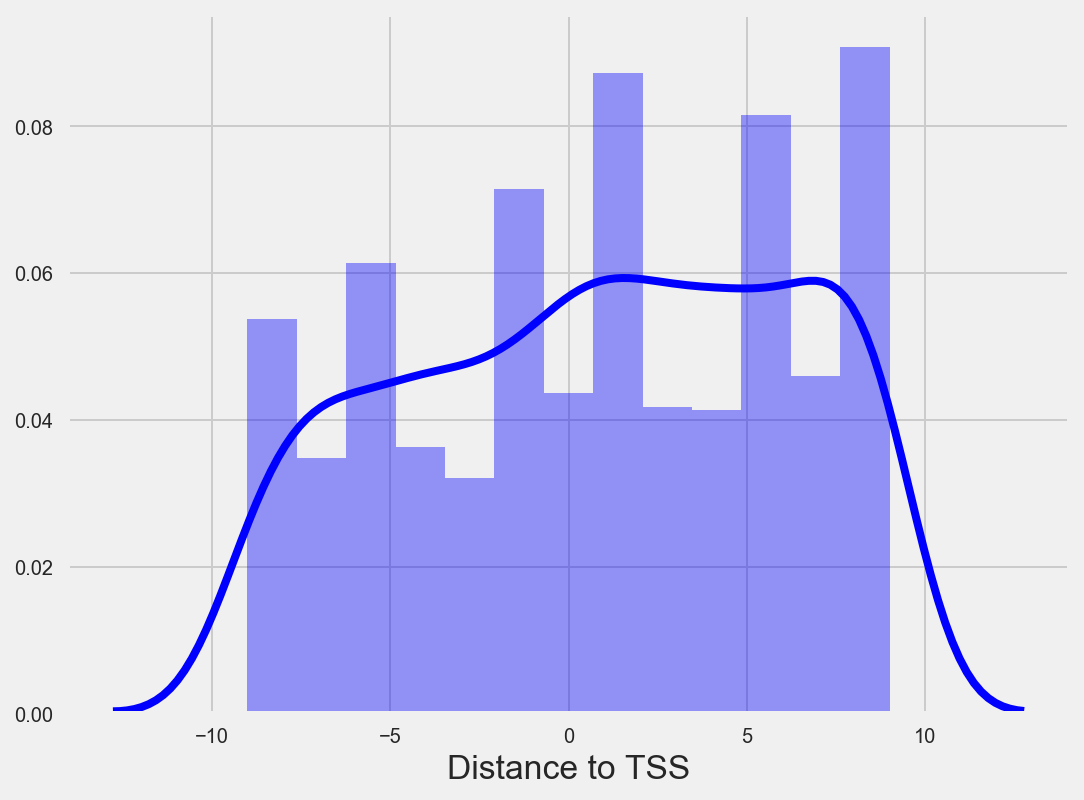

In [9]:
confident_promoter = anno_peaks[(np.abs(anno_peaks['Distance to TSS']) < 10) & anno_peaks['isSameStrand']]
sns.distplot(confident_promoter['Distance to TSS'])
print('Number of confident promoter peaks', confident_promoter.shape[0])


### Additional filter to only peaks with more than 1 tissue seen and cpm >1

In [10]:
sample_thresh = 2
cpm_thresh = 1

indices = peaks_tissue_merged.index.intersection(confident_promoter.index)
confident_promoter = confident_promoter.loc[indices]

confident_promoter_t2_cpm1 = confident_promoter[(
    (peaks_tissue_merged.loc[indices] > cpm_thresh).sum(axis=1) >=
    sample_thresh)]

confident_promoter_t2_cpm1.shape

(1156, 13)

### Same for ncRNA, but distance is over 40000 (arbitrary)

('Number of enhancer peaks', 50524)


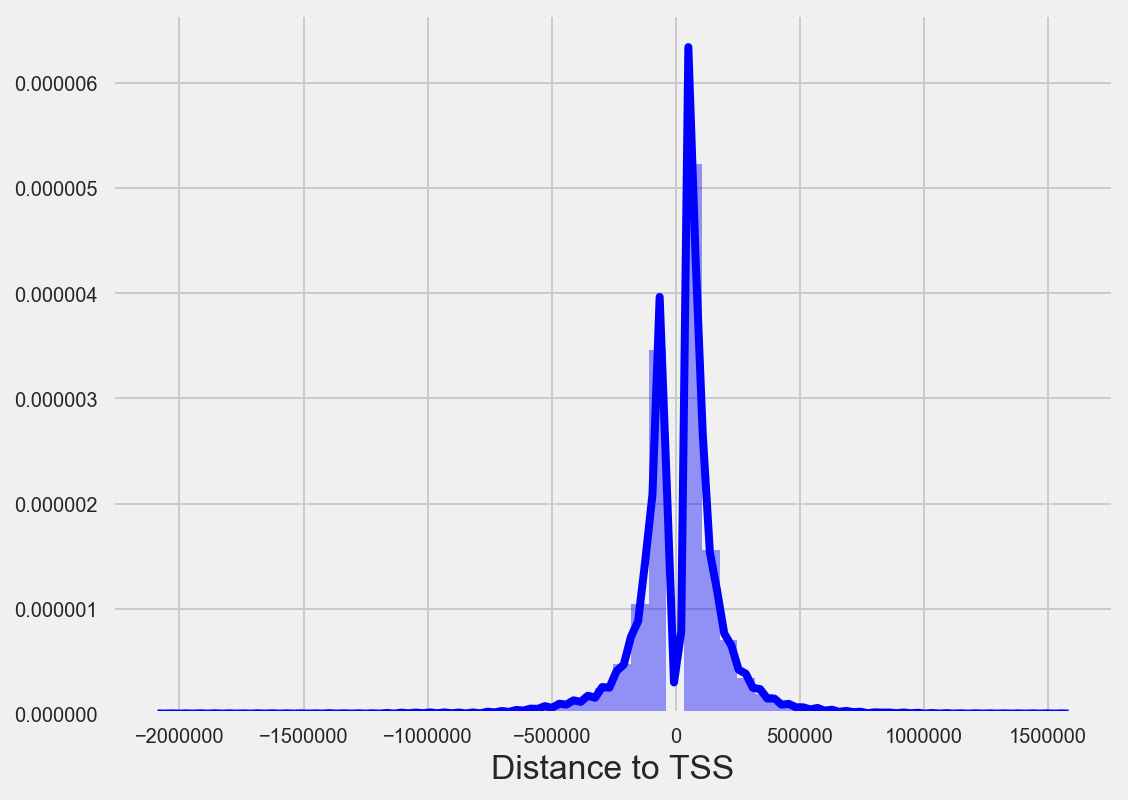

In [11]:
confident_enhancer = anno_peaks[(np.abs(anno_peaks['Distance to TSS']) > 40000) & anno_peaks['isSameStrand']]
sns.distplot(confident_enhancer['Distance to TSS'])
print('Number of enhancer peaks', confident_enhancer.shape[0])


In [12]:
sample_thresh = 2
cpm_thresh = 1

indices = peaks_tissue_merged.index.intersection(confident_enhancer.index)

confident_enhancer = confident_enhancer.loc[indices]

confident_enhancer_t2_cpm1 = confident_enhancer[(
    (peaks_tissue_merged.loc[indices] > cpm_thresh).sum(axis=1) >=
    sample_thresh)]

confident_enhancer_t2_cpm1.shape

(2893, 13)

#### Save different peaks to bed files

In [25]:
group_dir = 'Results/peak_groups/'

save_peak_as_bed(confident_enhancer_t2_cpm1,f_save = group_dir + 'confident_enhancer_t2_cpm1')
save_peak_as_bed(confident_promoter_t2_cpm1,f_save = group_dir + 'confident_promoter_t2_cpm1')

### b) High expressing promoters, low, and none

### No start site and no peaksWithin_1kb_100bp (meaning dont include the transcript if it had a peak in negative strand)

In [274]:
no_peaks = tss[tss['transcript_id'].isin(
    txn_df[(txn_df['Number of SS'] == 0)
           & (txn_df['bin_-1000_100'].apply(lambda x: x == []))].index)]

In [90]:
save_peak_as_bed(no_peaks,f_save=group_dir + 'noPeaks',score_col='')

In [172]:
for ind,val in tss[tss['transcript_id'].isin(txn_df.index)].iterrows():
    curr_strand = val['Strand']
    txn_df.set_value(val['transcript_id'],'Strand',curr_strand)

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [175]:
yesPeak = txn_df[txn_df['Number of SS'] > 0]
yesPeak = yesPeak[~yesPeak['maxValue'].isnull()]


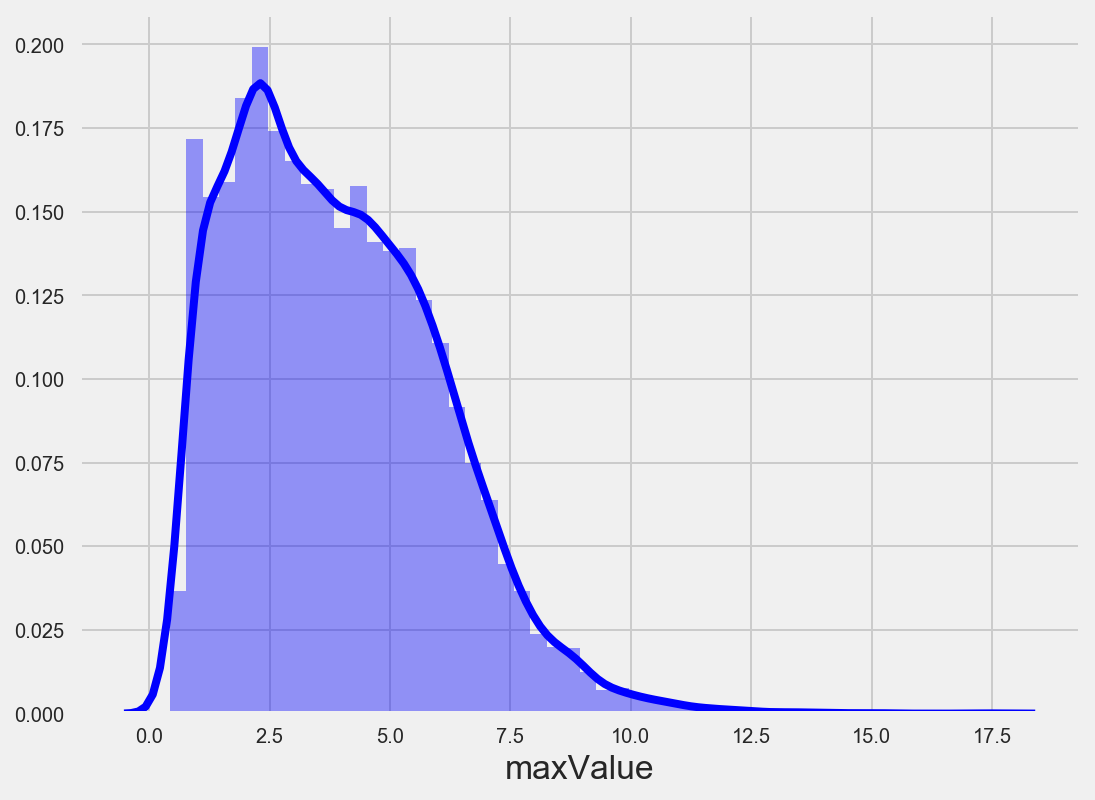

In [176]:
sns.distplot(np.log2(yesPeak['maxValue'].astype('float')+1))

In [184]:
out,bins = pd.qcut(yesPeak.maxValue,4,retbins=True,labels=[0,1,2,3])
low_val = yesPeak.loc[out[(out==0)].index]
high_val =yesPeak.loc[out[(out==3)].index]
twentyFive_val = yesPeak.loc[out[(out==1)].index]

In [178]:
save_peak_as_bed(low_val,f_save=group_dir + 'lowQuartile',score_col='maxValue')
save_peak_as_bed(high_val,f_save=group_dir + 'highQuartile',score_col='maxValue')

save_peak_as_bed(twentyFive_val,f_save=group_dir + 'twentyFive_val',score_col='maxValue')

In [180]:
low_val.head()

,peaks,numberOfPeaks,peaksWithin_1kb_100bp,promoterPeaks,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS,Strand,Name
asmbl_64,"[Merged-picr_0-457769-1, Merged-picr_0-457907-...",7,"[Merged-picr_0-456863-1, Merged-picr_0-457252-1]","[Merged-picr_0-456863-1, Merged-picr_0-457252-1]",[Liver_GRO],-37,Merged-picr_0-457252-1,3.35,Merged-picr_0-456863-1,[Liver_GRO],picr_0,456787,456937,gene_11,BIK,asmbl_64,True,2,+,asmbl_64
asmbl_56,"[Merged-picr_0-491033-6, Merged-picr_0-490850-1]",2,[Merged-picr_0-490850-1],[Merged-picr_0-490850-1],[BMDMwt_GRO],7,Merged-picr_0-490850-1,3.38,Merged-picr_0-490850-1,[BMDMwt_GRO],picr_0,490774,490924,gene_9,TSPO,asmbl_56,True,1,+,asmbl_56
asmbl_52,"[Merged-picr_0-519699-5, Merged-picr_0-520578-...",11,"[Merged-picr_0-519699-5, Merged-picr_0-520578-1]",[Merged-picr_0-520578-1],[BMDMwt_GRO],-990,Merged-picr_0-520578-1,2.63,Merged-picr_0-520578-1,[BMDMwt_GRO],picr_0,520502,520652,gene_8,TTLL12,asmbl_52,True,1,-,asmbl_52
asmbl_65,"[Merged-picr_0-649169-1, Merged-picr_0-648486-...",3,"[Merged-picr_0-649169-1, Merged-picr_0-648486-2]",[Merged-picr_0-649169-1],[Brain_GRO],-801,Merged-picr_0-649169-1,2.66,Merged-picr_0-649169-1,[Brain_GRO],picr_0,649093,649243,gene_12,SCUBE1,asmbl_65,True,1,-,asmbl_65
asmbl_67,"[Merged-picr_0-618891-1, Merged-picr_0-647326-...",8,[Merged-picr_0-647326-1],[Merged-picr_0-647326-1],[Brain_GRO],-31,Merged-picr_0-647326-1,2.46,Merged-picr_0-647326-1,[Brain_GRO],picr_0,647250,647400,gene_12,SCUBE1,asmbl_67,True,1,-,asmbl_67


In [181]:
high_val.head()

,peaks,numberOfPeaks,peaksWithin_1kb_100bp,promoterPeaks,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS,Strand,Name
asmbl_14,[Merged-picr_0-20959-16],1,[Merged-picr_0-20959-16],[Merged-picr_0-20959-16],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31,Merged-picr_0-20959-16,96.55,Merged-picr_0-20959-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,20878,21066,gene_1_4,SERHL,asmbl_14,True,1,+,asmbl_14
asmbl_31,"[Merged-picr_0-298206-10, Merged-picr_0-298535...",6,"[Merged-picr_0-298206-10, Merged-picr_0-298535-7]",[Merged-picr_0-298206-10],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",29,Merged-picr_0-298206-10,307.9,Merged-picr_0-298206-10,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",picr_0,298115,298308,gene_5_1,ARFGAP3,asmbl_31,True,1,-,asmbl_31
asmbl_43,"[Merged-picr_0-398822-16, Merged-picr_0-393327...",6,[Merged-picr_0-398822-16],[Merged-picr_0-398822-16],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",27,Merged-picr_0-398822-16,1197.35,Merged-picr_0-398822-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,398727,398917,gene_6,PACSIN2,asmbl_43,True,1,-,asmbl_43
asmbl_37,"[Merged-picr_0-363266-4, Merged-picr_0-364379-...",27,[Merged-picr_0-364379-11],[Merged-picr_0-364379-11],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",24,Merged-picr_0-364379-11,103.2,Merged-picr_0-364379-11,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,364263,364486,gene_6,PACSIN2,asmbl_37,True,1,-,asmbl_37
asmbl_49,"[Merged-picr_0-440919-12, Merged-picr_0-441054-4]",2,"[Merged-picr_0-440919-12, Merged-picr_0-441054-4]",[Merged-picr_0-440919-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",25,Merged-picr_0-440919-12,158.3,Merged-picr_0-440919-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,440835,440997,gene_7,TTLL1,asmbl_49,True,1,-,asmbl_49


In [280]:
noCHO = txn_df[txn_df['tissues'].apply(lambda x: np.array(map(lambda y: 'CHO' not in y,x)).any())]
noCHO = tss[tss['transcript_id'].apply(lambda x: x in noCHO.index)]

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length,actual_start
ID=asmbl_10;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_10;cs=1,picr_0,7821,44513,-,asmbl_10,gene_2,gene_2,RRP7A,asmbl_10,1,36692,44513
ID=asmbl_14;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_14;cs=2,picr_0,20942,38694,+,asmbl_14,gene_1_4,gene_1_4,SERHL,asmbl_14,2,17752,20942
ID=asmbl_19;Parent=gene_3_1;gene_id=gene_3_1;gene=POLDIP3;transcript_id=asmbl_19;cs=3,picr_0,64336,78255,-,asmbl_19,gene_3_1,gene_3_1,POLDIP3,asmbl_19,3,13919,78255
ID=asmbl_20;Parent=gene_3_2;gene_id=gene_3_2;gene=CYB5R3;transcript_id=asmbl_20;cs=2,picr_0,80930,92200,-,asmbl_20,gene_3_2,gene_3_2,CYB5R3,asmbl_20,2,11270,92200
ID=asmbl_24;Parent=gene_4_3;gene_id=gene_4_3;gene=A4GALT;transcript_id=asmbl_24;cs=1,picr_0,150498,186293,-,asmbl_24,gene_4_3,gene_4_3,A4GALT,asmbl_24,1,35795,186293
ID=asmbl_30;Parent=gene_4_3;gene_id=gene_4_3;gene=A4GALT;transcript_id=asmbl_30;cs=1,picr_0,150520,185721,-,asmbl_30,gene_4_3,gene_4_3,A4GALT,asmbl_30,1,35201,185721
ID=asmbl_31;Parent=gene_5_1;gene_id=gene_5_1;gene=ARFGAP3;transcript_id=asmbl_31;cs=1,picr_0,230695,298241,-,asmbl_31,gene_5_1,gene_5_1,ARFGAP3,asmbl_31,1,67546,298241
ID=asmbl_43;Parent=gene_6;gene_id=gene_6;gene=PACSIN2;transcript_id=asmbl_43;cs=1,picr_0,303940,398850,-,asmbl_43,gene_6,gene_6,PACSIN2,asmbl_43,1,94910,398850
ID=asmbl_37;Parent=gene_6;gene_id=gene_6;gene=PACSIN2;transcript_id=asmbl_37;cs=1,picr_0,303942,364399,-,asmbl_37,gene_6,gene_6,PACSIN2,asmbl_37,1,60457,364399
ID=asmbl_49;Parent=gene_7;gene_id=gene_7;gene=TTLL1;transcript_id=asmbl_49;cs=1,picr_0,414907,440942,-,asmbl_49,gene_7,gene_7,TTLL1,asmbl_49,1,26035,440942


In [287]:
tss_withPeaks = cho_prom_div['Nearest TSS'].unique()
tss[tss['transcript_id'].apply(lambda x: x in tss_withPeaks)] 

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length,actual_start
ID=asmbl_10;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_10;cs=1,picr_0,7821,44513,-,asmbl_10,gene_2,gene_2,RRP7A,asmbl_10,1,36692,44513
ID=asmbl_17;Parent=gene_3_1;gene_id=gene_3_1;gene=POLDIP3;transcript_id=asmbl_17;cs=1,picr_0,49679,98922,-,asmbl_17,gene_3_1,gene_3_1,POLDIP3,asmbl_17,1,49243,98922
ID=asmbl_33;Parent=gene_5_1;gene_id=gene_5_1;gene=ARFGAP3;transcript_id=asmbl_33;cs=1,picr_0,230702,275780,-,asmbl_33,gene_5_1,gene_5_1,ARFGAP3,asmbl_33,1,45078,275780
ID=asmbl_57;Parent=gene_10;gene_id=gene_10;gene=MCAT;transcript_id=asmbl_57;cs=1,picr_0,475040,491518,-,asmbl_57,gene_10,gene_10,MCAT,asmbl_57,1,16478,491518
ID=asmbl_59;Parent=gene_8;gene_id=gene_8;gene=TTLL12;transcript_id=asmbl_59;cs=1,picr_0,512025,519474,-,asmbl_59,gene_8,gene_8,TTLL12,asmbl_59,1,7449,519474
ID=asmbl_84;Parent=gene_19_4;gene_id=gene_19_4;gene=PARVB;transcript_id=asmbl_84;cs=1,picr_0,1125645,1214562,+,asmbl_84,gene_19_4,gene_19_4,PARVB,asmbl_84,1,88917,1125645
ID=asmbl_96;Parent=gene_23;gene_id=gene_23;gene=RTL6;transcript_id=asmbl_96;cs=2,picr_0,1445004,1451114,-,asmbl_96,gene_23,gene_23,RTL6,asmbl_96,2,6110,1451114
ID=asmbl_123;Parent=gene_28_1;gene_id=gene_28_1;gene=PHF21B;transcript_id=asmbl_123;cs=1,picr_0,1662581,1726422,-,asmbl_123,gene_28_1,gene_28_1,PHF21B,asmbl_123,1,63841,1726422
ID=asmbl_137;Parent=gene_33_1;gene_id=gene_33_1;gene=FAM118A;transcript_id=asmbl_137;cs=1,picr_0,1912931,1939478,+,asmbl_137,gene_33_1,gene_33_1,FAM118A,asmbl_137,1,26547,1912931
ID=asmbl_151;Parent=gene_38;gene_id=gene_38;gene=ATXN10;transcript_id=asmbl_151;cs=3,picr_0,2185898,2323347,+,asmbl_151,gene_38,gene_38,ATXN10,asmbl_151,3,137449,2185898
